In [ ]:
# Mandatory imports
%config InlineBackend.figure_format='retina'
from IPython.display import display, HTML

%matplotlib widget
%load_ext autoreload
%autoreload 2

from qubicpack.qubicfp import qubicfp
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (11,8)


In [1]:
# datapath = '/Volumes/HD-JC/QUBIC/QubicData/Calib-TD/'
datapath = '/Users/hamilton/Qubic/Data/CommissioningTD/'
day = '2025-05-13'
dataset = '2025-05-13_18.46.11__dome-open-V2'

a = qubicfp()
a.read_qubicstudio_dataset(datapath+day+'/'+dataset)

NameError: name 'qubicfp' is not defined

NameError: name 'a' is not defined

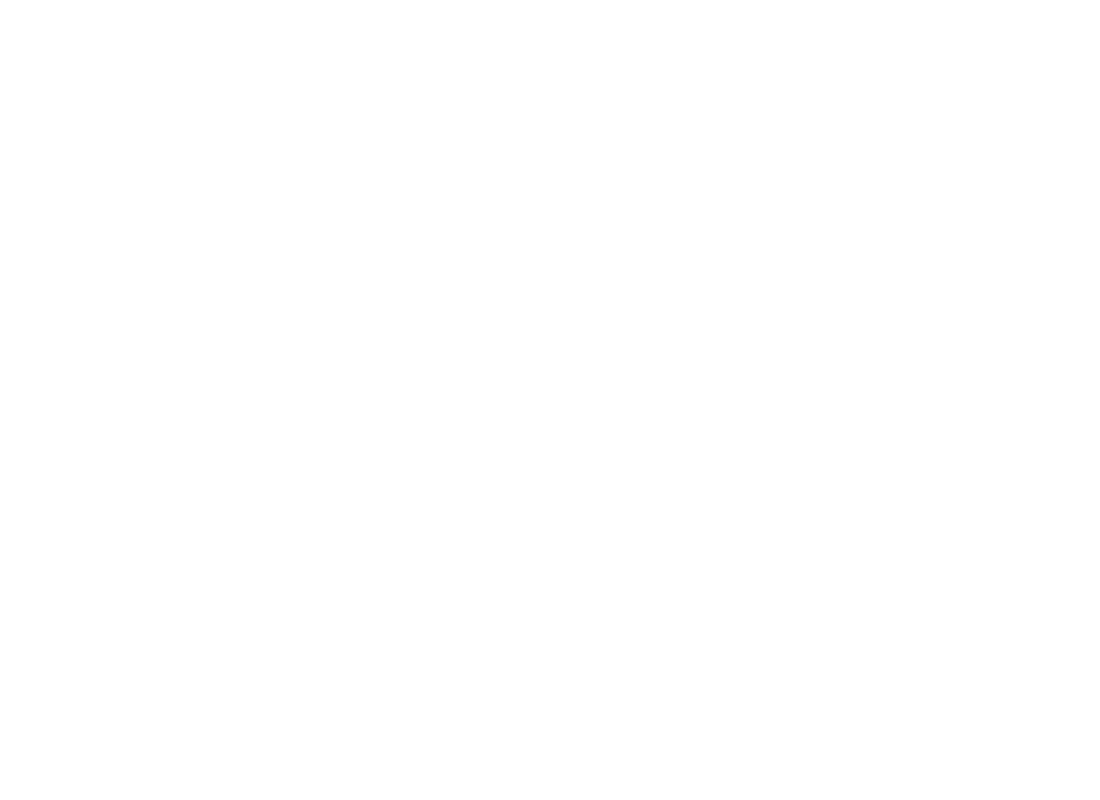

In [ ]:
plt.figure()
a.plot_timeline(TES=96, plot_Tbath=True)

In [ ]:
timeT, Tbath = a.Tbath
tTES, TOD = a.tod()
del(a)

suggest nsamples=6496256 which is  2^13*13*61


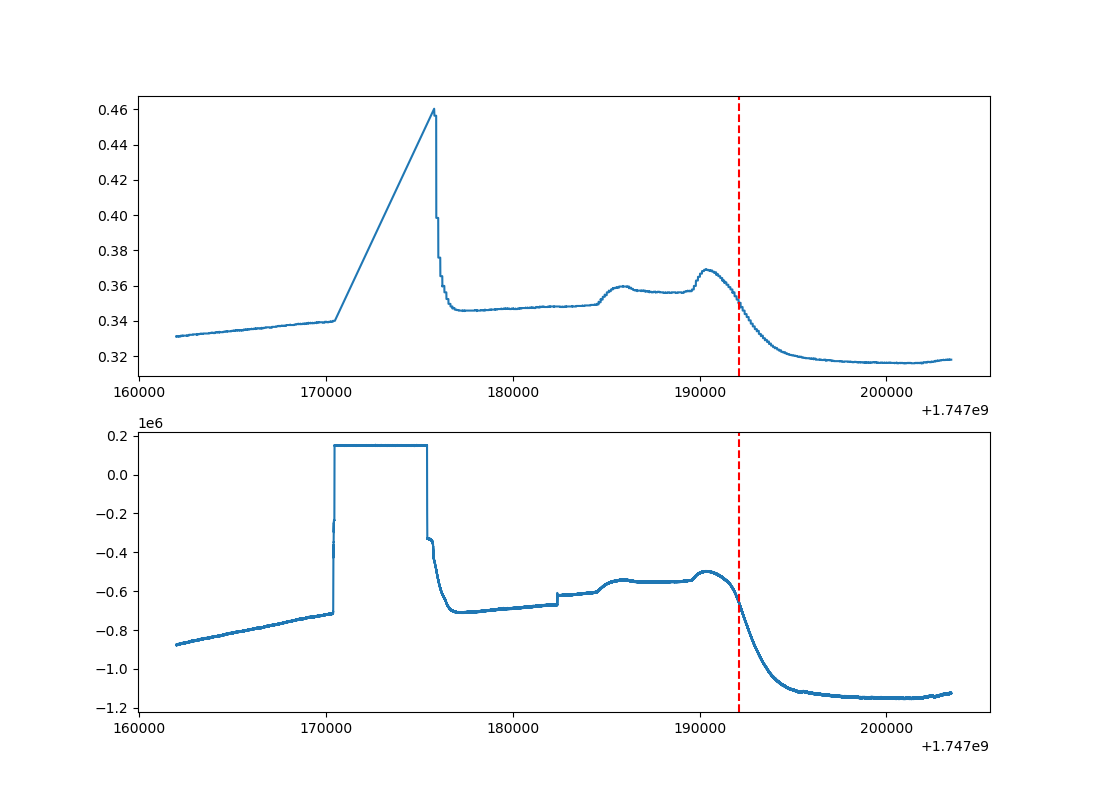

In [ ]:
TESNum = 96
TESindex = TESNum-1

Tmin = 0.350
ok = np.where((Tbath <= Tmin) & (timeT > (190000+1.747e9)))
tmin = np.min(timeT[ok])

oktes = tTES >= tmin

plt.figure()
plt.subplot(2,1,1)
plt.plot(timeT, Tbath)
plt.axvline(x=tmin, color='r', ls='--')

plt.subplot(2,1,2)   
plt.plot(tTES, TOD[TESindex,:])
plt.axvline(x=tmin, color='r', ls='--')


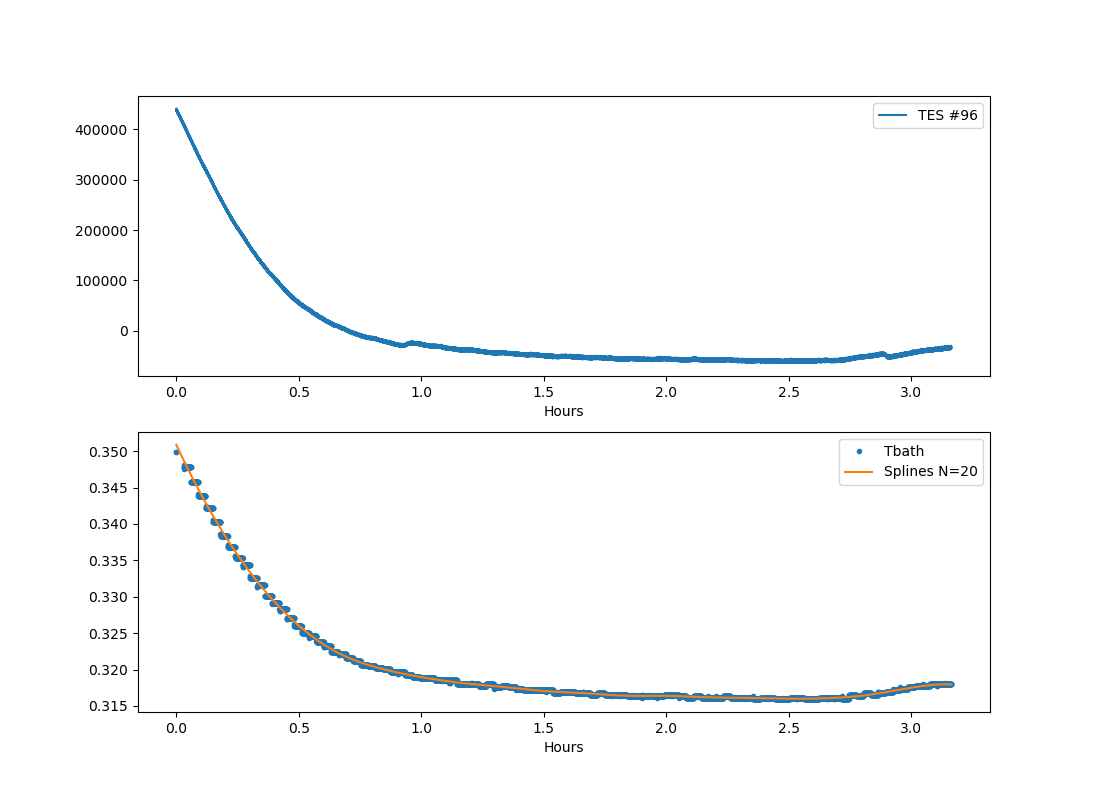

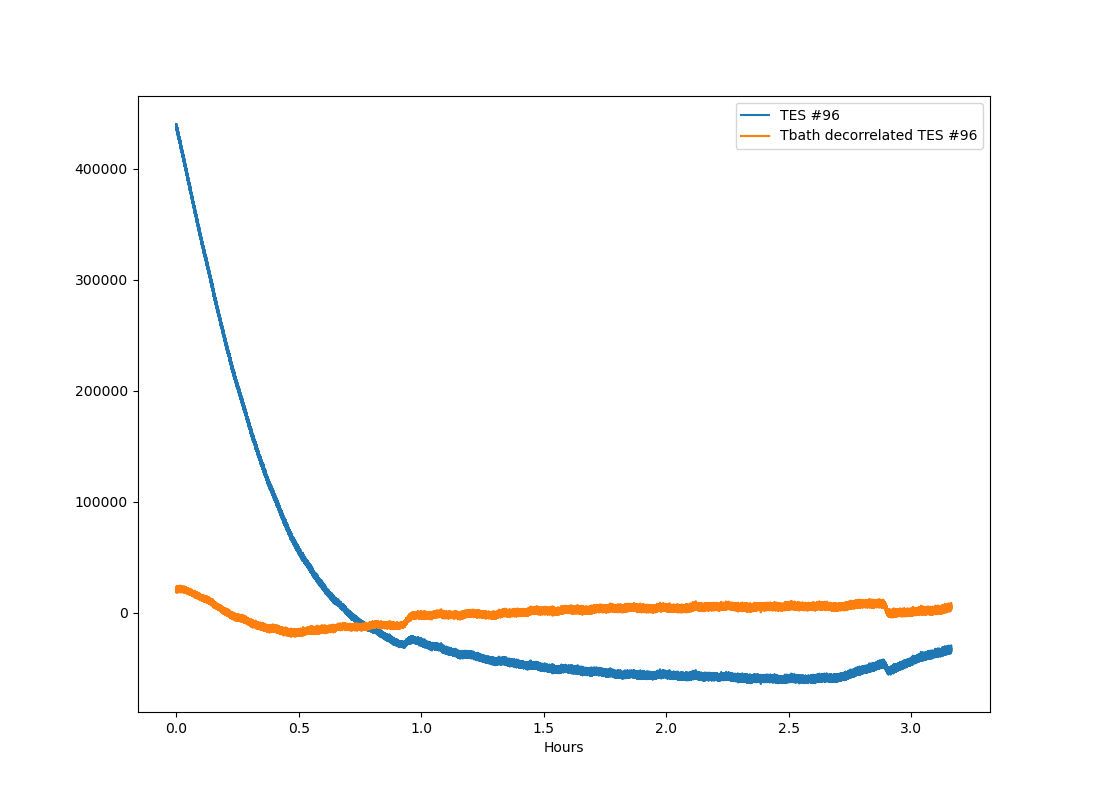

In [ ]:
# Let's select the zone where the temperature is stable and low
plt.figure()
plt.subplot(2,1,1)
plt.plot((tTES[oktes]-tmin)/3600, TOD[TESindex,oktes] - np.mean(TOD[TESindex,oktes]), label='TES #{}'.format(TESindex+1))
plt.xlabel('Hours')
plt.legend()

plt.subplot(2,1,2)   
plt.plot((timeT[ok]-tmin)/3600, Tbath[ok], '.', label='Tbath')
plt.xlabel('Hours')


### Modeling Tbath with splines
from qubic.lib.Qcoaddition import MySplineFitting
nbspl = 20
splfit = MySplineFitting((timeT[ok]-tmin)/3600, Tbath[ok], Tbath[ok]*0+1, nbspl)
plt.plot((timeT[ok]-tmin)/3600, splfit((timeT[ok]-tmin)/3600), label='Splines N={}'.format(nbspl))
plt.legend()

newtbath = splfit((tTES[oktes]-tmin)/3600)

# from scipy.fft import fft, ifft
# X1 = fft(TOD[TESindex,oktes], norm="ortho")
# X2 = fft(newtbath, norm="ortho")
# epsilon = 1e-12  # avoid division by zero
# H = (X1 * np.conj(X2)) / (X2 * np.conj(X2) + epsilon)
# X1_uncorrelated = X1 - H * X2
# newTES = np.real(ifft(X1_uncorrelated, norm="ortho"))

from sklearn.linear_model import LinearRegression

x1 = TOD[TESindex,oktes]
x2r = newtbath
x2r = newtbath.reshape(-1, 1)
model = LinearRegression().fit(x2r, x1)
newTES = x1 - model.predict(x2r)



plt.figure()
plt.plot((tTES[oktes]-tmin)/3600, TOD[TESindex,oktes] - np.mean(TOD[TESindex,oktes]), label='TES #{}'.format(TESindex+1))
plt.plot((tTES[oktes]-tmin)/3600, newTES, label='Tbath decorrelated TES #{}'.format(TESindex+1))
plt.xlabel('Hours')
plt.legend()





In [2]:
# do it differently

# nbspl2 = 10
# splfit = MySplineFitting((tTES[oktes]-tmin)/3600, newTES, newTES*0+1, nbspl2)
# plt.plot((tTES[oktes]-tmin)/3600, splfit((tTES[oktes]-tmin)/3600), label='Splines N={}'.format(nbspl2))


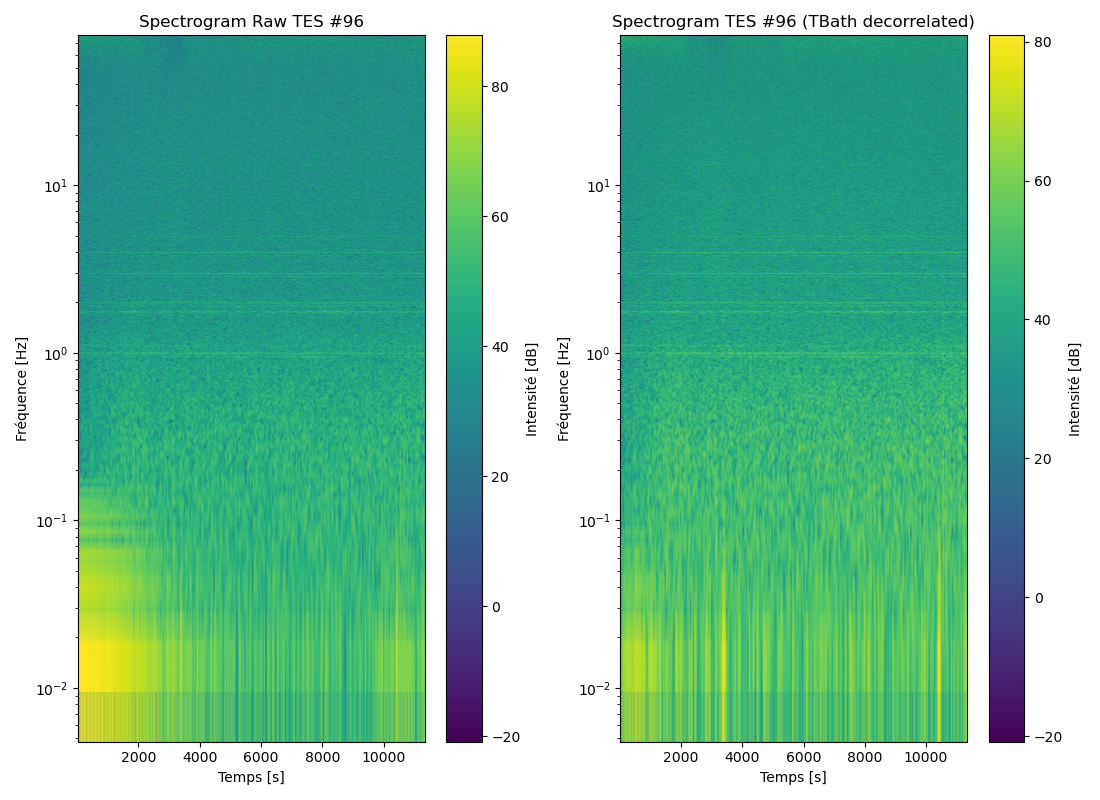

In [11]:
from scipy.signal import spectrogram

# Exemple : signal sinusoïdal modulé
fs = 1./(tTES[1]-tTES[0])  # Fréquence d’échantillonnage (Hz)
signal = TOD[TESindex,oktes]

# Analyse temps-fréquence
# Calcul du spectrogramme avec haute résolution fréquentielle
nperseg = 2048*4   # long segment = bonne résolution en fréquence
nfft = 4096*4      # zero-padding pour encore plus de bins
f, t_spec, Sxx = spectrogram(signal, fs, nperseg=nperseg, nfft=nfft)
fc, t_spec, Sxx_c = spectrogram(newTES, fs, nperseg=nperseg, nfft=nfft)



# Affichage
plt.figure()
plt.subplot(1,2,1)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.yscale('log')
plt.ylim(0.5*f[1], np.max(f))
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.title('Spectrogram Raw TES #{}'.format(TESindex+1))
plt.colorbar(label='Intensité [dB]')

plt.subplot(1,2,2)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx_c), shading='gouraud')
plt.yscale('log')
plt.ylim(0.5*f[1], np.max(f))
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.title('Spectrogram TES #{} (TBath decorrelated)'.format(TESindex+1))
plt.colorbar(label='Intensité [dB]')
plt.tight_layout()


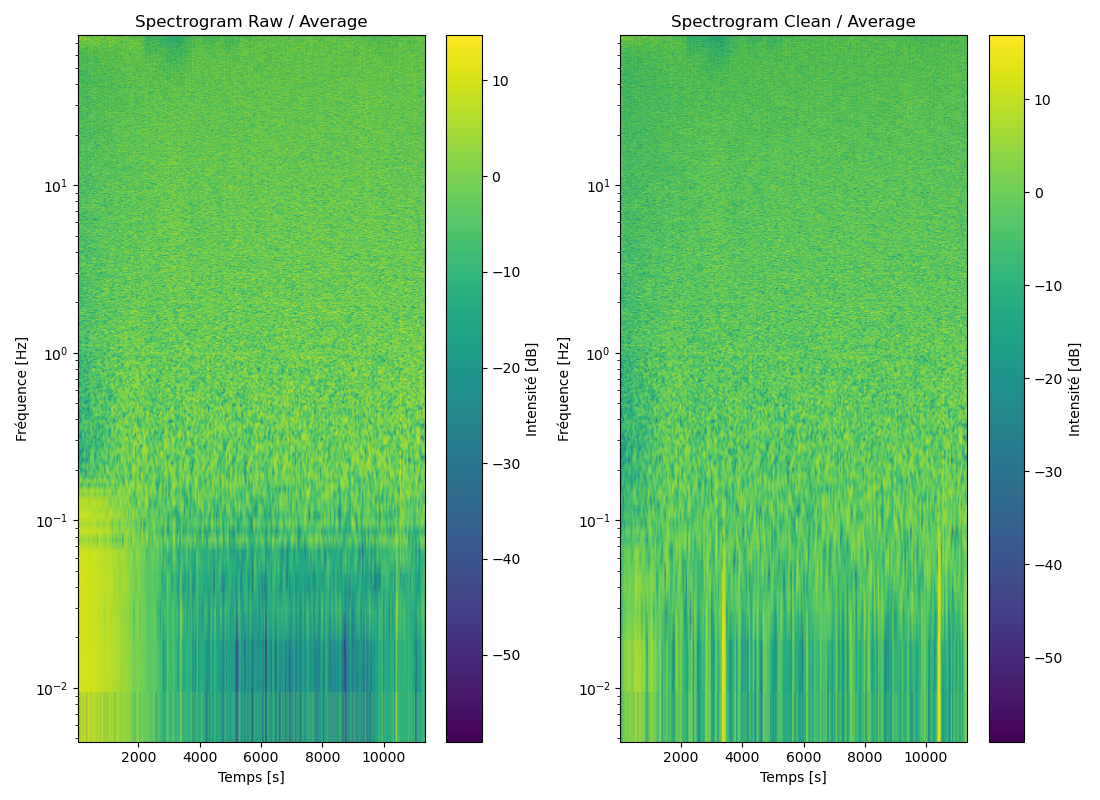

In [12]:
avspec = np.mean(Sxx,axis=1)
avspec_c = np.mean(Sxx_c,axis=1)


plt.figure()
plt.subplot(1,2,1)
plt.pcolormesh(t_spec, f, 10 * np.log10((Sxx.T/avspec.T).T), shading='gouraud')
plt.yscale('log')
plt.ylim(0.5*f[1], np.max(f))
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.title('Spectrogram Raw / Average')
plt.colorbar(label='Intensité [dB]')

plt.subplot(1,2,2)
plt.pcolormesh(t_spec, f, 10 * np.log10((Sxx_c.T/avspec_c.T).T), shading='gouraud')
plt.yscale('log')
plt.ylim(0.5*f[1], np.max(f))
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.title('Spectrogram Clean / Average')
plt.colorbar(label='Intensité [dB]')
plt.tight_layout()



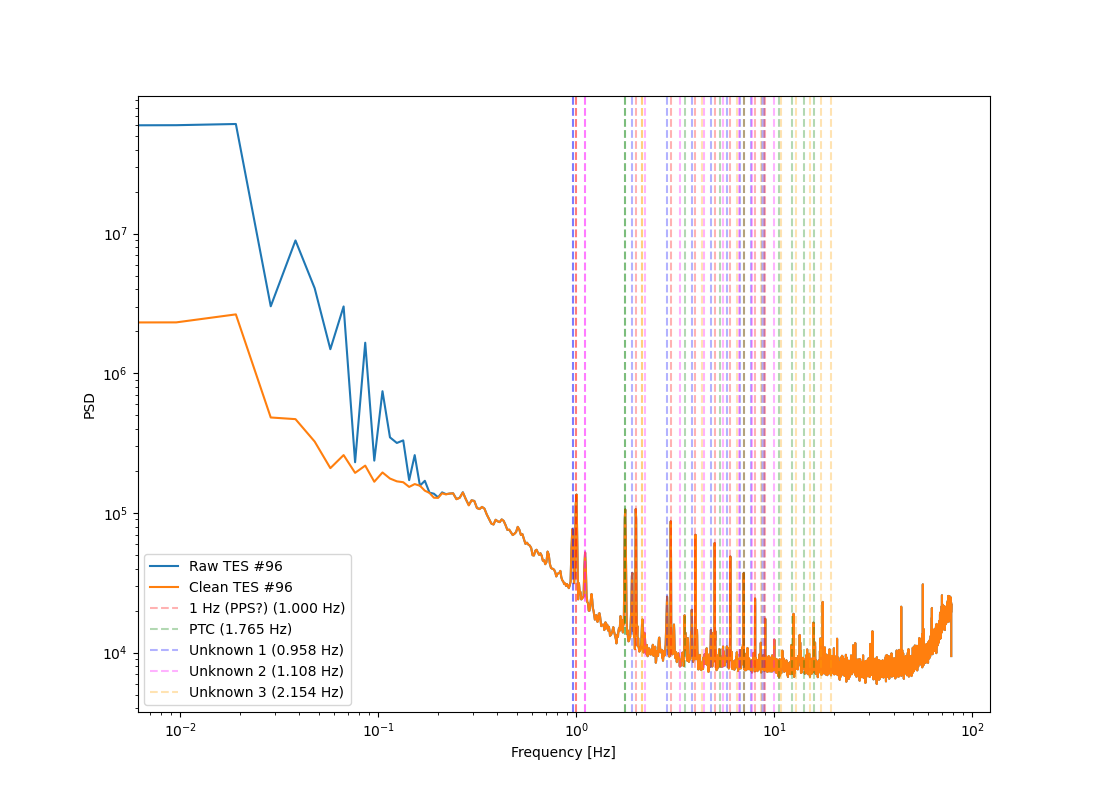

In [13]:
def plot_harms(f0, n, mylabel=None, **kwargs):
    """
    Plot the harmonics of a given fundamental frequency.
    """
    plt.axvline(x=f0, **kwargs, label=mylabel)
    for i in range(1, n):
        plt.axvline(x=f0*i, **kwargs)

def plot_all_peaks(peaks, **kwargs):
    for i in range(len(peaks)):
        plot_harms(peaks[i]['f0'], peaks[i]['n'], mylabel=peaks[i]['label']+' ({0:5.3f} Hz)'.format(peaks[i]['f0']), color=peaks[i]['color'], **kwargs)


p_pps = {'label': '1 Hz (PPS?)',
        'f0': 1.,
        'n': 10,
        'color': 'red'}
p_PTC = {'label': 'PTC',
        'f0': 1.765,
        'n': 10,
        'color': 'green'}
p_u1 = {'label': 'Unknown 1',
        'f0': 0.958,
        'n': 10,
        'color': 'blue'}
p_u2 = {'label': 'Unknown 2',
        'f0': 1.108,
        'n': 10,
        'color': 'magenta'}
p_u3 = {'label': 'Unknown 3',
        'f0': 2.154,
        'n': 10,
        'color': 'orange'}

peaks = [p_pps, p_PTC, p_u1, p_u2, p_u3]



avspec = np.mean(Sxx,axis=1)



plt.figure()
plt.plot(f, avspec, label='Raw TES #{}'.format(TESindex+1))
plt.plot(f, avspec_c, label='Clean TES #{}'.format(TESindex+1))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plot_all_peaks(peaks, ls='--', alpha=0.3)
plt.legend()

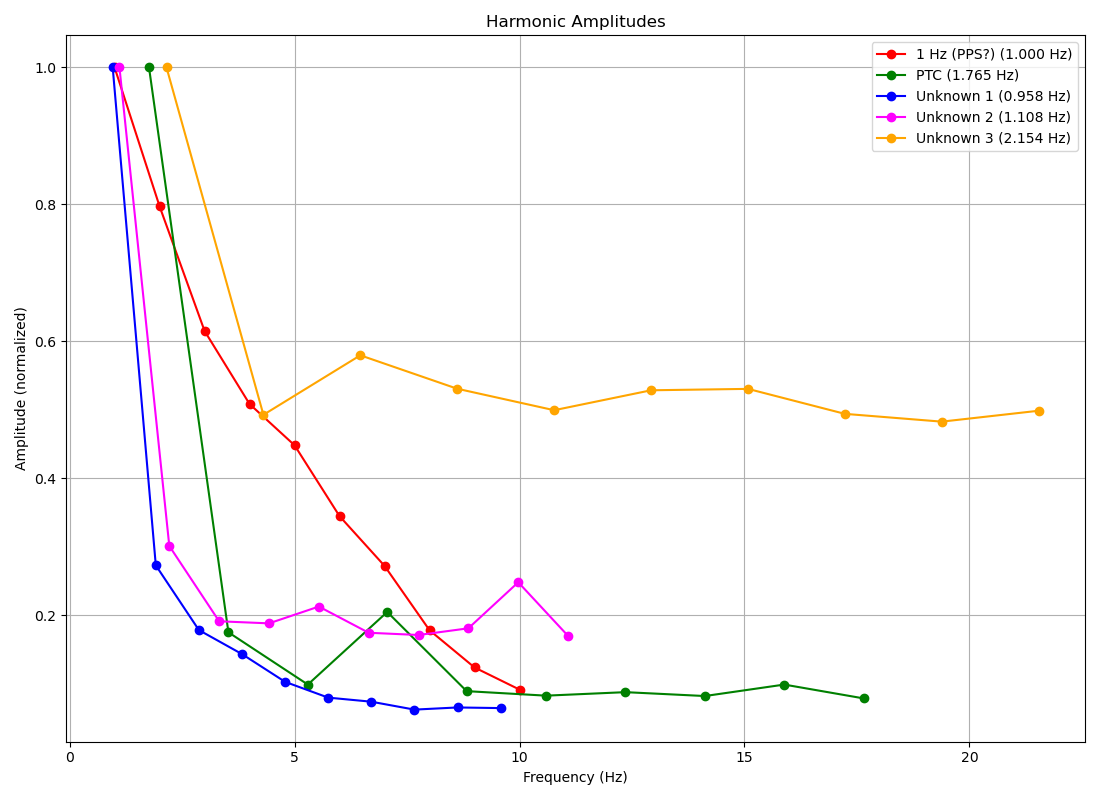

In [14]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

def get_harmonic_amplitudes_interp(frequencies, spectrum, f0, n_harmonics, window=0.05, step=0.001, norm=False):
    """
    Estimates harmonic amplitudes by cubic interpolation around each harmonic frequency.
    
    Parameters:
        frequencies : np.array
            Frequency axis (same length as spectrum)
        spectrum : np.array
            1D PSD or FFT spectrum
        f0 : float
            Fundamental frequency
        n_harmonics : int
            Number of harmonics to extract
        window : float
            Half-width of the frequency window around each harmonic (Hz)
        step : float
            Frequency resolution for interpolation (Hz)
    
    Returns:
        list of floats : peak amplitudes (interpolated) for each harmonic
    """
    interp_func = interp1d(frequencies, spectrum, kind='cubic', bounds_error=False, fill_value=0)
    amplitudes = []
    for i in range(1, n_harmonics + 1):
        f_center = f0 * i
        f_range = np.arange(f_center - window, f_center + window, step)
        s_interp = interp_func(f_range)
        amplitude = np.max(s_interp)
        amplitudes.append(amplitude)
    harmonics_freqs = [f0 * i for i in range(1, n_harmonics + 1)]
    if norm:
        if amplitudes[0] != 0:
            amplitudes = amplitudes / amplitudes[0]
        else:
            amplitudes = np.zeros_like(amplitudes)
    return harmonics_freqs, amplitudes

average_spectrum = np.mean(Sxx, axis=1)


plt.figure()
for peak in peaks:
    h_freqs, amplitudes = get_harmonic_amplitudes_interp(
        f, average_spectrum,
        f0=peak['f0'], norm=True,
        n_harmonics=peak['n'],
        window=0.05, step=0.001
    )
    plt.plot(h_freqs, amplitudes, marker='o',
             label=f"{peak['label']} ({peak['f0']:.3f} Hz)",
             color=peak['color'])
#plt.yscale('log')  # or 'linear' depending on your dynamic range
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (normalized)')
plt.title('Harmonic Amplitudes')
plt.grid(True)
plt.legend()
plt.tight_layout()


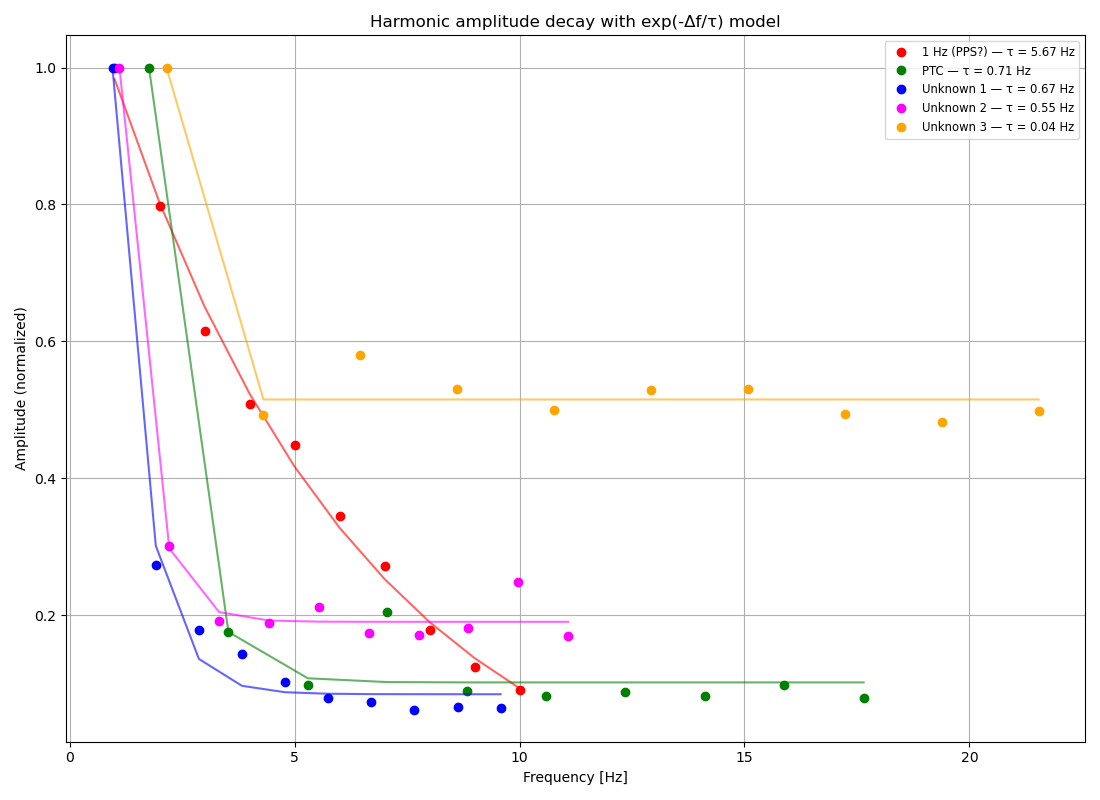

In [15]:
from scipy.optimize import curve_fit

def get_exp_decay_model_from_f0(f0):
    def model(i, A0, tau, C):
        freqs = i * f0
        return A0 * np.exp(-(freqs - f0) / tau) + C
    return model

plt.rcParams['figure.figsize'] = (11,8)

plt.figure()
for peak in peaks:
    i_vals = np.arange(1, peak['n'] + 1)
    freqs, amps = get_harmonic_amplitudes_interp(
        f, average_spectrum,
        f0=peak['f0'], norm=True,
        n_harmonics=peak['n'],
        window=0.05, step=0.001
    )

    model = get_exp_decay_model_from_f0(peak['f0'])

    try:
        popt, _ = curve_fit(model, i_vals, amps, p0=[1.0, 5.0, 0.01])
        fitted = model(i_vals, *popt)
        label = f"{peak['label']} — τ = {popt[1]:.2f} Hz"
        #label = f"{peak['label']} ({peak['f0']:.3f} Hz)\nτ = {popt[1]:.2f}, C = {popt[2]:.3f}"
    except RuntimeError:
        fitted = None
        label = f"{peak['label']} — τ = {popt[1]:.2f} Hz"
        #label = f"{peak['label']} ({peak['f0']:.3f} Hz)\n(Fit failed)"

    plt.plot(i_vals * peak['f0'], amps, 'o', color=peak['color'], label=label)
    if fitted is not None:
        plt.plot(i_vals * peak['f0'], fitted, '-', color=peak['color'], alpha=0.6)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude (normalized)")
plt.title("Harmonic amplitude decay with exp(-Δf/τ) model")
plt.grid(True)
plt.legend(fontsize='small')
plt.tight_layout()
